**Project Title : Emotion Detection from Text**

Objective : The main aim of this project is to build the effective model to predict the human emotions such as Happy, Sad, Anger etc., based on the content.   

In [122]:
#importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#!pip install xgboost
import xgboost as xgb

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Kaggle projects/Emotion Detection')

**Data Loading**

In [147]:
df=pd.read_csv("tweet_emotions.csv")
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


**Data Exploration**

In [5]:
print(df.shape)
df.info()

(40000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
df.isna().sum()

,0
tweet_id,0
sentiment,0
content,0


In [10]:
df[df.duplicated('tweet_id')]

,tweet_id,sentiment,content


**Data Preprocessing**

In [148]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocessing function with lemmatization
def wp1(text):
    # Lowercase conversion
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    # Reconstruct text from tokens
    lemma_cleaned_content = ' '.join(tokens)
    return lemma_cleaned_content

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [149]:
# Apply the function
df['lemma_cleaned_content'] = df['content'].apply(wp1)

In [24]:
df.head(10)

,tweet_id,sentiment,content,lemma_cleaned_content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhh waitin call
2,1956967696,sadness,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone houston ticke...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,ping ghostridah go prom bc bf like friend
6,1956968487,sadness,"I should be sleep, but im not! thinking about ...",sleep im think old friend want married damn am...
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down,hmmm
8,1956969035,sadness,@charviray Charlene my love. I miss you,charviray charlene love miss
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?,kelcouch sorry least friday


**Exploratory Data Analysis**

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64


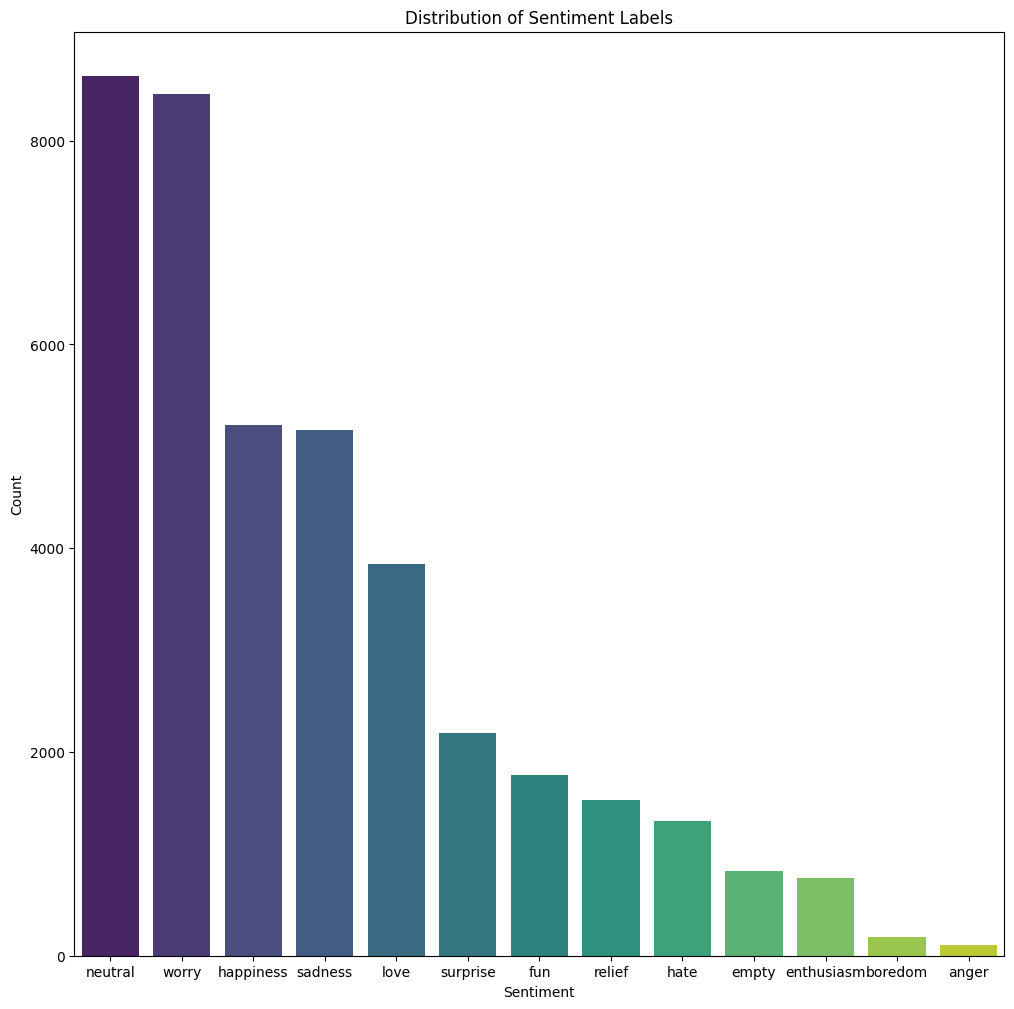

In [90]:
# Distribution of Sentiment Labels
class_distribution = df['sentiment'].value_counts()
print(class_distribution)

plt.figure(figsize=(12, 12))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

**Observation:** This plot shows the distribution of sentiment labels in the dataset. Neutral & Worry classes having the highest counts i.e, more than 8000 tweets. However, Anger and boredom are having lowest count i.e, less than 1000 tweets.

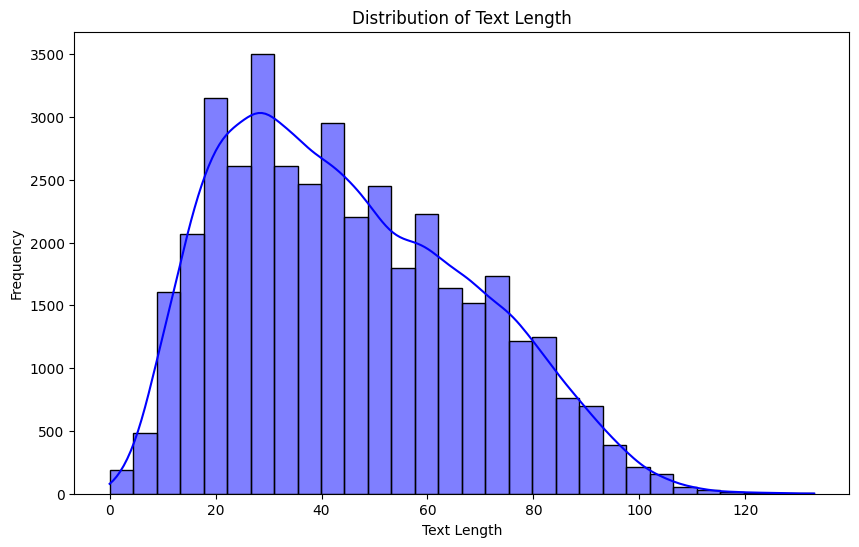

In [93]:
# Text Length Distribution
df['text_length'] = df['lemma_cleaned_content'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

**Observation:**
The histogram shows a right-skewed distribution of text lengths, peaking around 30-40 characters. Most texts are short, while longer texts are less frequent.

**Vectorization**

In [150]:
X = df['lemma_cleaned_content']
y = df['sentiment']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [95]:
#Apply TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000)  # Limit to top 10000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Matrix Shape:", X_train_tfidf.shape)

TF-IDF Matrix Shape: (32000, 10000)


In [96]:
tfidf_feature_names = tfidf.get_feature_names_out()
print("First 20 words in the vocabulary:")
print(tfidf_feature_names[:20])

First 20 words in the vocabulary:
['__' '_bella_cullen' '_enigma__' '_erica' '_handz_' '_supernatural_'
 '_writersblock_' '_xotashhh' 'a_nobel' 'aa' 'aaaaa' 'aaaaaaaaaamazing'
 'aaaaaah' 'aaaaahhhh' 'aaaah' 'aaah' 'aaahhh' 'aaass' 'aaaw' 'aaaww']


In [97]:
# Check TF-IDF scores for the first 5 documents
dense_tfidf = X_train_tfidf.todense()
for doc_num in range(5):
    doc_tfidf = dense_tfidf[doc_num].tolist()[0]
    tfidf_scores_doc = [(word, doc_tfidf[i]) for i, word in enumerate(tfidf_feature_names)]
    tfidf_scores_doc_sorted = sorted(tfidf_scores_doc, key=lambda x: x[1], reverse=True)

    print(f"\nTop 5 words by TF-IDF score in document {doc_num + 1}:")
    for word, score in tfidf_scores_doc_sorted[:5]:
        print(f"{word}: {score:.4f}")


Top 5 words by TF-IDF score in document 1:
equal: 0.6285
baseball: 0.5907
plus: 0.5060
__: 0.0000
_bella_cullen: 0.0000

Top 5 words by TF-IDF score in document 2:
crew: 0.4780
hangover: 0.4297
hilarious: 0.4151
movie: 0.2910
could: 0.2762

Top 5 words by TF-IDF score in document 3:
work: 0.4366
til: 0.3835
pm: 0.3804
least: 0.3499
game: 0.3398

Top 5 words by TF-IDF score in document 4:
madd: 0.5204
stick: 0.4154
work: 0.4092
freakin: 0.4089
till: 0.3244

Top 5 words by TF-IDF score in document 5:
mean: 0.5194
address: 0.3774
jack: 0.3484
lucky: 0.3012
hehe: 0.3002


**Modelling**

In [107]:
#Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_tfidf, y_train)
y_pred = log_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.34875
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.33      0.01      0.01       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.04      0.01      0.01       338
   happiness       0.34      0.36      0.35      1028
        hate       0.51      0.16      0.25       268
        love       0.50      0.38      0.43       762
     neutral       0.34      0.57      0.43      1740
      relief       0.33      0.03      0.05       352
     sadness       0.35      0.25      0.29      1046
    surprise       0.36      0.05      0.08       425
       worry       0.33      0.47      0.39      1666

    accuracy                           0.35      8000
   macro avg       0.26      0.18      0.18      8000
weighted avg       0.34      0.35      0.31      8000



In [99]:
#Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.308125
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.35      0.22      0.27      1028
        hate       0.00      0.00      0.00       268
        love       0.54      0.22      0.31       762
     neutral       0.30      0.53      0.39      1740
      relief       0.00      0.00      0.00       352
     sadness       0.34      0.07      0.11      1046
    surprise       0.00      0.00      0.00       425
       worry       0.28      0.65      0.40      1666

    accuracy                           0.31      8000
   macro avg       0.14      0.13      0.11      8000
weighted avg       0.27      0.31      0.24      8000



In [79]:
# Random Forest
RandomForest_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
RandomForest_classifier.fit(X_train_tfidf, y_train)
y_pred = RandomForest_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("Classification report of Random Forest model:")
print(classification_report(y_test, y_pred))


Accuracy: 0.3315
Classification report of Random Forest model:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.16      0.03      0.05       338
   happiness       0.31      0.34      0.32      1028
        hate       0.37      0.19      0.25       268
        love       0.44      0.40      0.42       762
     neutral       0.33      0.53      0.41      1740
      relief       0.15      0.02      0.03       352
     sadness       0.35      0.25      0.29      1046
    surprise       0.17      0.03      0.05       425
       worry       0.32      0.45      0.37      1666

    accuracy                           0.33      8000
   macro avg       0.20      0.17      0.17      8000
weighted avg       0.30      0.33      0.30      8000



In [182]:
#SVM
SV_classifier = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
SV_classifier.fit(X_train_tfidf, y_train)
y_pred = SV_classifier.predict(X_test_tfidf)

print("Classification report of Support Vector Classifier:")
print(classification_report(y_test, y_pred))

Classification report of Support Vector Classifier:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.35      0.28      0.31      1028
        hate       0.47      0.14      0.22       268
        love       0.50      0.34      0.41       762
     neutral       0.30      0.70      0.42      1740
      relief       1.00      0.00      0.01       352
     sadness       0.46      0.09      0.15      1046
    surprise       0.00      0.00      0.00       425
       worry       0.33      0.44      0.37      1666

    accuracy                           0.33      8000
   macro avg       0.26      0.15      0.14      8000
weighted avg       0.34      0.33      0.27      8000



In [102]:
#KNN training and evaluation
KNN_Classifier = KNeighborsClassifier(n_neighbors=5)
KNN_Classifier.fit(X_train_tfidf, y_train)
y_pred = KNN_Classifier.predict(X_test_tfidf)

print("Classification report of KNN Classifier:")
print(classification_report(y_test, y_pred))

Classification report of KNN Classifier:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.02      0.05      0.02       162
  enthusiasm       0.02      0.01      0.01       163
         fun       0.04      0.01      0.01       338
   happiness       0.23      0.12      0.16      1028
        hate       0.25      0.07      0.11       268
        love       0.28      0.12      0.17       762
     neutral       0.23      0.70      0.34      1740
      relief       0.05      0.00      0.01       352
     sadness       0.31      0.08      0.12      1046
    surprise       0.11      0.02      0.03       425
       worry       0.25      0.09      0.14      1666

    accuracy                           0.21      8000
   macro avg       0.14      0.10      0.09      8000
weighted avg       0.22      0.21      0.16      8000



In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [155]:
xgb_Classifier = xgb.XGBClassifier()
xgb_Classifier = xgb_Classifier.fit(X_train_tfidf, y_train_encoded)

y_pred = xgb_Classifier.predict(X_test_tfidf)

print("Classification report of XGBoost Classifier:")
print(classification_report(y_test_encoded, y_pred))

Classification report of XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        31
           2       0.33      0.01      0.02       162
           3       0.00      0.00      0.00       163
           4       0.14      0.02      0.04       338
           5       0.32      0.29      0.31      1028
           6       0.39      0.21      0.27       268
           7       0.47      0.39      0.43       762
           8       0.33      0.66      0.44      1740
           9       0.23      0.03      0.05       352
          10       0.39      0.26      0.31      1046
          11       0.28      0.06      0.10       425
          12       0.34      0.39      0.36      1666

    accuracy                           0.35      8000
   macro avg       0.25      0.18      0.18      8000
weighted avg       0.33      0.35      0.31      8000



**LSTM**

In [177]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Use original text data here
X_train_seq = tokenizer.texts_to_sequences(X_train) #Converts text to sequences of word indices
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len) #Ensures all sequences have the same length.
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [178]:
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Define Model
num_classes = y_train_cat.shape[1]

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(num_classes, activation='softmax'))  # multi classification

# Compile Model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [179]:
# Train Model
model_lstm.fit(X_train_pad, y_train_cat, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test_cat))

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 139s 133ms/step - accuracy: 0.2365 - loss: 2.1921 - val_accuracy: 0.3409 - val_loss: 1.9408
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - accuracy: 0.3731 - loss: 1.8946 - val_accuracy: 0.3536 - val_loss: 1.9114
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.4364 - loss: 1.7571 - val_accuracy: 0.3451 - val_loss: 1.9458
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.4796 - loss: 1.6313 - val_accuracy: 0.3419 - val_loss: 2.0293
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 138s 129ms/step - accuracy: 0.5254 - loss: 1.4968 - val_accuracy: 0.3206 - val_loss: 2.1056
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.5694 - loss: 1.3737 - val_accuracy: 0.3190 - val_loss: 2.2188
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 145s 132ms/step - accuracy: 0.5965 - loss: 1.2913 - val_accuracy: 0.3114 - val_loss: 2.3576
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 143s 133ms/step - ac

In [181]:
# Evaluate the LSTM model
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test_cat)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.3021 - loss: 2.8413
Test Loss: 2.8684
Test Accuracy: 0.3051
